In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
init_printing()

## PDE 
The VTI wave equation for the square slowness m, thomsen parametersd $\epsilon$ and $\delta$ for 3D  and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 p(x,t)}{dt^2} - (1+2\epsilon)(\frac{d^2 p(x,t)}{dx^2}+ \frac{d^2 p(x,t)}{dy^2}) - \sqrt{(1+2\delta)} \frac{d^2 r(x,t)}{dz^2} =q  \\
 &m \frac{d^2 r(x,t)}{dt^2} - \sqrt{(1+2\delta)}(\frac{d^2 p(x,t)}{dx^2}+ \frac{d^2 p(x,t)}{dy^2}) - \frac{d^2 r(x,t)}{dz^2} =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution

It correspondto a velocity model where the velocity in the z direction is different from the velocity in the xy plane

In [2]:
p=Function('p')
r=Function('r')
m,s,h = symbols('m s h')
m=M(x,y)
q=Q(x,y,t)
d=D(x,y,t)
e=E(x,y)

A=epsilon(x,y)
B=delta(x,y)

In [3]:
dttp=as_finite_diff(p(x,y,t).diff(t,t), [t-s,t, t+s])
dttr=as_finite_diff(r(x,y,t).diff(t,t), [t-s,t, t+s])
dtp=as_finite_diff(p(x,y,t).diff(t), [t-s,t])
dtr=as_finite_diff(r(x,y,t).diff(t), [t-s,t])
# Spacial finite differences can easily be extended to higher order by increasing the list of sampling point in the next expression. 
# Be sure to keep this stencil symmetric and everything else in the notebook will follow.
dxxp=as_finite_diff(p(x,y,t).diff(x,x), [x-h,x, x+h]) 
dyyp=as_finite_diff(p(x,y,t).diff(y,y), [y-h,y, y+h])
dxxr=as_finite_diff(r(x,y,t).diff(x,x), [x-h,x, x+h]) 
dyyr=as_finite_diff(r(x,y,t).diff(y,y), [y-h,y, y+h])

In [4]:
# Forward wave equation
wavep = m*dttp -(1+2*A) *dxxp - sqrt(1+2*B)* dyyr - q  + e*dtp
stencilp = solve(wavep,p(x,y,t+s))[0]
stencilp
tsp=lambdify((p(x,y,t-s),p(x-h,y,t), p(x,y,t), p(x+h,y,t), r(x,y,t),r(x,y-h,t), r(x,y+h,t), q , m, s, h,A,B,e),stencilp,"numpy")

In [5]:
waver = m*dttr -sqrt(1+2*B)* dxxp -  dyyr - q  + e*dtr
stencilr = solve(waver,r(x,y,t+s))[0]
stencilr
tsr=lambdify((r(x,y,t-s),p(x-h,y,t), p(x,y,t), p(x+h,y,t), r(x,y,t),r(x,y-h,t), r(x,y+h,t), q , m, s, h,A,B,e),stencilr,"numpy")

## PDE Adjoint
The VTI adjoint wave equation for the square slowness m, thomsen parametersd $\epsilon$ and $\delta$ for 3D  and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 p(x,t)}{dt^2} - (\frac{d^2 ((1+2\epsilon)p(x,t))}{dx^2}+ \frac{d^2 ((1+2\epsilon)p(x,t))}{dy^2}) -  \frac{d^2 \sqrt{(1+2\delta)} r(x,t)}{dz^2} =q  \\
 &m \frac{d^2 r(x,t)}{dt^2} - (\frac{d^2 \sqrt{(1+2\delta)}p(x,t)}{dx^2}+ \frac{d^2 \sqrt{(1+2\delta)}p(x,t)}{dy^2}) - \frac{d^2 r(x,t)}{dz^2} =q  \\
 &u(.,T) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=T} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution

It correspondto a velocity model where the velocity in the z direction is different from the velocity in the xy plane

In [29]:
# Adjoint wave equation


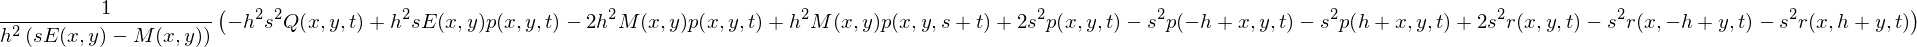

In [31]:
import matplotlib.pyplot as plt
from matplotlib import animation

hstep=20 #space increment d  = minv/(10*f0);
tstep=1 #time increment dt < .5 * hstep /maxv;
tmin=0.0 #initial time
tmax=600 #simulate until
xmin=-500.0 - 10*hstep #left bound
xmax=500.0 + 10*hstep #right bound...assume packet never reaches boundary
ymin=-500.0 - 10*hstep #left bound
ymax=500.0 + 10*hstep #right bound...assume packet never reaches boundary
f0=.010
t0=1/.010
nbpml=10
nx = int((xmax-xmin)/hstep) + 1 #number of points on x grid
ny = int((ymax-ymin)/hstep) + 1 #number of points on x grid
nt = int((tmax-tmin)/tstep) + 2 #number of points on t grid
xsrc=-400
ysrc=0.0
xrec = nbpml+4
#set source as Ricker wavelet for f0 
def source(x,y,t):
    r = (np.pi*f0*(t-t0))
    val = (1-2.*r**2)*np.exp(-r**2)
    if abs(x-xsrc)<hstep/2 and abs(y-ysrc)<hstep/2:
        return val
    else:
        return 0.0
    
def dampx(x):
    dampcoeff=np.log(1.0/0.001)/(5.0*hstep);
    if x<nbpml:
        return dampcoeff*((nbpml-x)/nbpml)**2
    elif x>nx-nbpml-1:
        return dampcoeff*((x-nx+nbpml)/nbpml)**2
    else:
        return 0.0
def dampy(y):
    dampcoeff=np.log(1.0/0.001)/(5.0*hstep);
    if y<nbpml:
        return dampcoeff*((nbpml-y)/nbpml)**2
    elif y>ny-nbpml-1:
        return dampcoeff*((y-ny+nbpml)/nbpml)**2
    else:
        return 0.0

In [32]:
# Velocity models
def smooth10(vel,nx,ny):
    out=np.ones((nx,ny))
    out[:,:]=vel[:,:]
    for a in range(5,nx-6):
        out[a,:]=np.sum(vel[a-5:a+5,:], axis=0) /10
    return out

# True velocity
vel=np.ones((nx,ny)) + 2.0
vel[floor(nx/2):nx,:]=4.5
mt=vel**-2
# Smooth velocity
v0=smooth10(vel,nx,ny)
m0=v0**-2
eps=np.ones((nx,ny)) -.8
delt=np.ones((nx,ny)) -.9
dm=m0-mt

In [33]:
def Forward(nt,nx,ny,m,eps,delt):
    u1=np.zeros((nt,nx,ny))
    u2=np.zeros((nt,nx,ny))
    rec=np.zeros((nt,ny-2))
    for ti in range(0,nt):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                src = source(xmin+a*hstep,ymin+b*hstep,tstep*ti)
                damp=dampx(a)+dampy(b)
                if ti==0:
                    u1[ti,a,b]=tsp(0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   .5*src, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   eps[a,b], 
                                   delt[a,b], 
                                   damp)
                elif ti==1:
                    u1[ti,a,b]=tsp(0, 
                                   u1[ti-1,a-1,b], 
                                   u1[ti-1,a,b], 
                                   u1[ti-1,a+1,b], 
                                   u2[ti-1,a,b], 
                                   u2[ti-1,a,b-1], 
                                   u2[ti-1,a,b+1], 
                                   .5*src, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   eps[a,b], 
                                   delt[a,b], 
                                   damp)
                else:
                    u1[ti,a,b]=tsp(u1[ti-2,a,b], 
                                   u1[ti-1,a-1,b], 
                                   u1[ti-1,a,b], 
                                   u1[ti-1,a+1,b], 
                                   u2[ti-1,a,b], 
                                   u2[ti-1,a,b-1], 
                                   u2[ti-1,a,b+1], 
                                   .5*src, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   eps[a,b], 
                                   delt[a,b], 
                                   damp)
                if ti==0:
                    u2[ti,a,b]=tsr(0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   .5*src, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   eps[a,b], 
                                   delt[a,b], 
                                   damp)
                elif ti==1:
                    u2[ti,a,b]=tsr(0, 
                                   u1[ti-1,a-1,b], 
                                   u1[ti-1,a,b], 
                                   u1[ti-1,a+1,b], 
                                   u2[ti-1,a,b], 
                                   u2[ti-1,a,b-1], 
                                   u2[ti-1,a,b+1], 
                                   .5*src, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   eps[a,b], 
                                   delt[a,b], 
                                   damp)
                else:
                    u2[ti,a,b]=tsr(u2[ti-2,a,b], 
                                   u1[ti-1,a-1,b], 
                                   u1[ti-1,a,b], 
                                   u1[ti-1,a+1,b], 
                                   u2[ti-1,a,b], 
                                   u2[ti-1,a,b-1], 
                                   u2[ti-1,a,b+1], 
                                   .5*src, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   eps[a,b], 
                                   delt[a,b], 
                                   damp)
                if a==xrec :
                    rec[ti,b-1]=(u1[ti,a,b] + u2[ti,a,b])
    return rec,u1,u2

In [34]:
def Adjoint(nt,nx,ny,m,rec,eps,delt):
    u1=np.zeros((nt,nx,ny))
    u2=np.zeros((nt,nx,ny))
    srca=np.zeros((nt))
    for ti in range(nt-1, -1, -1):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                damp=dampx(a)+dampy(b)
                if a==xrec:
                    resid=rec[ti,b-1]
                else:
                    resid=0
                if ti==nt-1:
                    u1[ti,a,b]=tspa(0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   .5*resid, 
                                   m[a,b], 
                                   tstep, 
                                   hstep,  
                                   -damp)
                elif ti==nt-2:
                    u1[ti,a,b]=tspa(0, 
                                   (1 + 2 * eps[a-1,b])*u1[ti+1,a-1,b], 
                                   (1 + 2 * eps[a,b])*u1[ti+1,a,b], 
                                   (1 + 2 * eps[a+1,b])*u1[ti+1,a+1,b], 
                                   np.sqrt(1 + 2 * delt[a,b])*u2[ti+1,a,b], 
                                   np.sqrt(1 + 2 * delt[a,b-1])*u2[ti+1,a,b-1], 
                                   np.sqrt(1 + 2 * delt[a,b+1])*u2[ti+1,a,b+1], 
                                   .5*resid, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   -damp)
                else:
                    u1[ti,a,b]=tspa(u1[ti+2,a,b], 
                                   (1 + 2 * eps[a-1,b])*u1[ti+1,a-1,b], 
                                   (1 + 2 * eps[a,b])*u1[ti+1,a,b], 
                                   (1 + 2 * eps[a+1,b])*u1[ti+1,a+1,b], 
                                   np.sqrt(1 + 2 * delt[a,b])*u2[ti+1,a,b], 
                                   np.sqrt(1 + 2 * delt[a,b-1])*u2[ti+1,a,b-1], 
                                   np.sqrt(1 + 2 * delt[a,b+1])*u2[ti+1,a,b+1], 
                                   .5*resid, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   -damp)
                if ti==nt-1:
                    u2[ti,a,b]=tsra(0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   0, 
                                   .5*resid, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   -damp)
                elif ti==nt-2:
                    u2[ti,a,b]=tsra(0, 
                                   np.sqrt(1 + 2 * delt[a-1,b])*u1[ti+1,a-1,b], 
                                   np.sqrt(1 + 2 * delt[a,b])*u1[ti+1,a,b], 
                                   np.sqrt(1 + 2 * delt[a+1,b])*u1[ti+1,a+1,b], 
                                   u2[ti+1,a,b], 
                                   u2[ti+1,a,b-1], 
                                   u2[ti+1,a,b+1], 
                                   .5*resid, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   -damp)
                else:
                    u2[ti,a,b]=tsra(u2[ti+2,a,b], 
                                   np.sqrt(1 + 2 * delt[a-1,b])*u1[ti+1,a-1,b], 
                                   np.sqrt(1 + 2 * delt[a,b])*u1[ti+1,a,b], 
                                   np.sqrt(1 + 2 * delt[a+1,b])*u1[ti+1,a+1,b], 
                                   u2[ti+1,a,b], 
                                   u2[ti+1,a,b-1], 
                                   u2[ti+1,a,b+1], 
                                   .5*resid, 
                                   m[a,b], 
                                   tstep, 
                                   hstep, 
                                   -damp)
                if abs(xmin+a*hstep-xsrc)<hstep/2 and abs(ymin+b*hstep-ysrc)<hstep/2:
                    srca[ti]=(u1[ti,a,b]+u2[ti,a,b])
    return srca

In [ ]:
(rect,u1,u2)=Forward(nt,nx,ny,mt,eps,delt)

In [ ]:

fig = plt.figure()
plts = []             # get ready to populate this list the Line artists to be plotted
plt.hold("off")
for i in range(nt):
    r = plt.imshow(u01[i,:,:],vmin=-10,vmax=10)   # this is how you'd plot a single line...
    plts.append( [r] )  
ani = animation.ArtistAnimation(fig, plts, interval=50,  repeat = False)   # run the animation
plt.show()

In [ ]:
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(rect)   # this is how you'd plot a single line...
plt.show()

# Adjoint test

In ordr to guaranty we have the gradient we need to make sure that the solution of the adjoint wave equation is indeed the true adjoint. Tod os so one should check that

$ <Ax,y> - <x,A^Ty> = 0$

where $A$ is the wave_equation,  $A^T$ is wave_equationA and $x,y$ are any random vectors in the range of each operator. This can however be expensive as this two vector would be of size $N * n_t$. To test our operator we will the relax this test by

$ <P_r A P_s^T x,y> - <x,P_SA^TP_r^Ty> = 0$

where $P_r , P_s^T$ are the source and recevier projection operator mapping the source and receiver locations and times onto the full domain. This allow to have only a random source of size $n_t$ at a random postion.

In [12]:
(rec0,u01,u02)=Forward(nt,nx,ny,m0,eps,delt)

In [35]:
srca=Adjoint(nt,nx,ny,m0,rec0,eps,delt)

In [36]:
# Actual adjoint test
term1=0
for ti in range(0,nt):
    term1=term1+srca[ti]*source(xsrc,ysrc,(ti)*tstep)

term2=LA.norm(rec0)**2

term1,term2,term1-term2,term1/term2

In [ ]:
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.imshow(rec0)   # this is how you'd plot a single line...
plt.show()

In [28]:
fig2 = plt.figure()
plt.hold("off")
shotrec = plt.plot(srca)   # this is how you'd plot a single line...
plt.show()